In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import xgboost as xgb 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from category_encoders import TargetEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression          
from sklearn.model_selection import cross_val_score

plt.rcParams['font.family'] = 'Malgun Gothic'
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [509]:
gdf = gpd.read_file("C:/Users/User/Desktop/파이썬/연습문제/venv/practical_project/csv/point_1.shp")

In [510]:
df = pd.read_csv("C:/Users/User/Desktop/파이썬/연습문제/venv/실전프로젝트/farm.csv", encoding="cp949")

# 전처리

In [511]:
df_drop = df[df["농장아이디"]==20261].index
df.drop(df_drop, inplace=True)

In [512]:
df.drop("체세포", axis=1, inplace=True)
df.drop("수집건수", axis=1, inplace=True)
df.drop("측정일시", axis=1, inplace=True)
df.drop("축종코드", axis=1, inplace=True)
df.drop("제조사 아이디", axis=1, inplace=True)
df.drop("수집일자", axis=1, inplace=True)

In [513]:
# 혈액흐름 전처리
df["혈액흐름"] = df["혈액흐름"].apply(lambda x : 0 if x == "N" else 1)

In [514]:
df["착유시작일시"] = pd.to_datetime(df["착유시작일시"], format="%Y-%m-%d %H:%M")
df["착유종료일시"] = pd.to_datetime(df["착유종료일시"], format="%Y-%m-%d %H:%M")

# 파생변수

In [517]:
df["착유시간"] = df["착유종료일시"] - df["착유시작일시"]

In [518]:
df["착유시간"]  = df["착유시간"].dt.total_seconds() / 60  # 분 단위로 변환

In [519]:
# 가정 (개체번호 앞 7자리는 생년월일)
df_birth = df['개체번호'].astype(str).str[:8]
df_birthdt = pd.to_datetime(df_birth, format='%Y%m%d', errors='coerce')

def calculate_age(birth_date, current_date):

    # 만 나이 계산 로직
    # 현재 연도 - 출생 연도 - 불리언(생일이 현재 날짜보다 뒤에 있으면 1 빼기)
    age = current_date.year - birth_date.year - ((current_date.month, current_date.day) < (birth_date.month, birth_date.day))
    return age

current_analysis_date = datetime(2021, 10, 1)
df['나이'] = df_birthdt.apply(lambda x: calculate_age(x, current_analysis_date))

In [520]:
# 개체별 일일착유량 계산 
df["측정일"] = df["착유시작일시"].dt.day
df_count1 = df.groupby(["개체번호","측정일"])["착유량"].sum().reset_index()
df_count1.rename(columns={"착유량": "개체별 일일착유량"}, inplace=True)
df = df.merge(df_count1, on=["개체번호", "측정일"], how="left")

In [521]:
df["개체별 일일착유량"].isnull().sum()

np.int64(0)

In [522]:
# 개체별 착유일수 계산
df_count2 = df.groupby("개체번호")["측정일"].nunique().reset_index()
df_count2.rename(columns={"측정일": "개체별 착유일수"}, inplace=True)
df = df.merge(df_count2, on="개체번호", how="left")

In [523]:
df["개체별 착유일수"].isnull().sum()

np.int64(0)

In [ ]:
df["P/F ratio"] = df["유단백"]/ df["유지방"]

In [525]:
df["착유효율"] = df["착유량"] / df["착유시간"]

In [526]:
df["공기흐름_비율"] = df["공기흐름"] / df["착유시간"]

## 결측치

In [527]:
cd = df["유지방"].isnull()
cd_index = cd[cd].index
df.drop(cd_index, inplace=True)

# 이상치

In [495]:
df.columns

Index(['농장아이디', '개체번호', '착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도', '혈액흐름', '온도',
       '유지방', '유단백', '공기흐름', '착유시간', '나이', '측정일', '개체별 일일착유량', '개체별 착유일수',
       'P/F ratio', '착유효율', '공기흐름_비율'],
      dtype='object')

In [543]:
outlier_columns = ['착유량',
    '착유회차',
    '전도도',
    '온도',
    '유지방',
    '유단백',
    '공기흐름',
    '착유시간']

for column_name in outlier_columns:
    Q1 = df_clean[column_name].quantile(0.25)
    Q3 = df_clean[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # 이상치에 해당하는 행의 인덱스 확인
    outliers_indices = df_clean[(df_clean[column_name] < lower_bound) | (df_clean[column_name] > upper_bound)].index
    
    # 이상치 제거
    df_clean = df_clean.drop(outliers_indices).reset_index(drop=True)

In [544]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21050 entries, 0 to 21049
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   농장아이디      21050 non-null  int64         
 1   개체번호       21050 non-null  int64         
 2   착유량        21050 non-null  int64         
 3   착유시작일시     21050 non-null  datetime64[ns]
 4   착유종료일시     21050 non-null  datetime64[ns]
 5   착유회차       21050 non-null  int64         
 6   전도도        21050 non-null  float64       
 7   혈액흐름       21050 non-null  int64         
 8   온도         21050 non-null  float64       
 9   유지방        21050 non-null  float64       
 10  유단백        21050 non-null  float64       
 11  공기흐름       21050 non-null  float64       
 12  착유시간       21050 non-null  float64       
 13  나이         21050 non-null  int64         
 14  측정일        21050 non-null  int32         
 15  개체별 일일착유량  21050 non-null  int64         
 16  개체별 착유일수   21050 non-null  int64        

## 공기흐름

In [332]:
c = df[(df["공기흐름"]>=3) & (df["공기흐름"]<4.1)]

In [333]:
c["착유량"].mean()

np.float64(11.900802221536562)

In [334]:
df[df["공기흐름"]==9.4]

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름
25198,20264,20170810020047,12,2021-09-07 02:26:00,2021-09-07 02:33:00,1,7.1,0,39.1,4.1,3.1,9.4


In [336]:
df["착유시간"] = df["착유종료일시"]-df["착유시작일시"]

In [337]:
df["착유시간"]  = df["착유시간"].dt.total_seconds() / 60  # 분 단위로 변환

In [357]:
df[(df["착유시간"] > 15) & (df["공기흐름"]<5)]

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,착유시간
235,20278,20150218010032,26,2021-09-26 16:23:00,2021-09-26 16:41:00,2,6.8,0,40.2,5.4,3.1,1.7,18.0
961,20278,20170710010068,19,2021-09-17 07:05:00,2021-09-17 07:21:00,1,7.7,0,40.6,4.9,3.4,1.4,16.0
962,20278,20170710010068,24,2021-09-18 06:00:00,2021-09-18 06:16:00,1,8.2,0,40.5,4.2,3.3,1.9,16.0
2532,20338,20150102020102,15,2021-09-26 08:04:00,2021-09-26 09:24:00,1,6.5,0,38.7,4.1,3.7,3.5,80.0
3468,20338,20160927020016,13,2021-09-21 08:45:00,2021-09-21 09:01:00,2,6.9,0,39.0,3.3,3.2,2.9,16.0
3741,20338,20161010020156,18,2021-09-06 00:44:00,2021-09-06 01:00:00,1,7.8,0,39.3,3.3,3.1,1.9,16.0
3747,20338,20161010020156,24,2021-09-07 06:38:00,2021-09-07 06:54:00,1,8.1,0,39.0,2.5,3.3,1.7,16.0
3820,20338,20161010020156,20,2021-09-24 08:03:00,2021-09-24 08:20:00,1,7.8,0,37.9,2.4,3.4,1.6,17.0
3831,20338,20161010020156,34,2021-09-26 18:21:00,2021-09-26 18:38:00,1,7.8,0,39.3,1.6,3.7,2.4,17.0
4195,20338,20161021020021,3,2021-09-02 06:01:00,2021-09-02 06:35:00,1,6.4,0,38.1,4.6,3.7,3.5,34.0


In [365]:
df[(df["착유시간"]>=20) & (df["착유회차"]==1)]

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,착유시간
2532,20338,20150102020102,15,2021-09-26 08:04:00,2021-09-26 09:24:00,1,6.5,0,38.7,4.1,3.7,3.5,80.0
4195,20338,20161021020021,3,2021-09-02 06:01:00,2021-09-02 06:35:00,1,6.4,0,38.1,4.6,3.7,3.5,34.0
23758,20264,20140315020075,14,2021-09-23 02:34:00,2021-09-23 02:54:00,1,7.7,0,37.7,3.9,3.2,1.0,20.0
26819,20264,20180821020070,16,2021-09-22 05:57:00,2021-09-22 06:18:00,1,7.1,0,38.8,4.5,2.9,1.1,21.0
27442,20264,20190701020010,7,2021-09-08 17:29:00,2021-09-08 17:50:00,1,7.4,0,39.0,4.4,3.7,1.8,21.0


In [400]:
df[df["공기흐름"]<1].head(10)

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,착유시간
1793,20278,20180903010007,3,2021-09-21 07:24:00,2021-09-21 07:30:00,1,7.9,0,39.9,0.6,3.8,0.9,6.0
1794,20278,20180903010007,3,2021-09-21 17:09:00,2021-09-21 17:18:00,2,7.6,0,38.7,0.9,3.8,0.8,9.0
2503,20338,20150102020102,1,2021-09-19 10:45:00,2021-09-19 11:00:00,1,7.1,0,34.2,1.0,3.9,0.6,15.0
4210,20338,20161021020021,0,2021-09-08 04:58:00,2021-09-08 05:01:00,1,7.0,0,34.6,NaN,NaN,0.2,3.0
4228,20338,20161021020021,0,2021-09-14 16:39:00,2021-09-14 16:42:00,2,8.2,0,36.9,5.9,3.7,0.6,3.0
4233,20338,20161021020021,1,2021-09-16 16:41:00,2021-09-16 16:45:00,1,7.6,0,37.7,5.5,3.9,0.8,4.0
4234,20338,20161021020021,0,2021-09-17 04:38:00,2021-09-17 04:42:00,1,9.3,0,35.6,6.7,3.2,0.4,4.0
4237,20338,20161021020021,0,2021-09-19 16:21:00,2021-09-19 16:26:00,1,7.6,0,35.8,6.2,3.8,0.7,5.0
4238,20338,20161021020021,0,2021-09-21 05:00:00,2021-09-21 05:06:00,1,4.7,0,32.4,NaN,NaN,0.3,6.0
4240,20338,20161021020021,0,2021-09-23 16:18:00,2021-09-23 16:24:00,1,2.1,0,31.9,NaN,NaN,0.4,6.0


In [401]:
df[df["개체번호"]==20161021020021]

,농장아이디,개체번호,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,착유시간
4193,20338,20161021020021,5,2021-09-01 06:21:00,2021-09-01 06:27:00,1,6.6,0,38.8,5.3,3.6,4.3,6.0
4195,20338,20161021020021,3,2021-09-02 06:01:00,2021-09-02 06:35:00,1,6.4,0,38.1,4.6,3.7,3.5,34.0
4197,20338,20161021020021,2,2021-09-02 15:59:00,2021-09-02 16:03:00,2,6.3,0,38.4,5.4,3.7,1.7,4.0
4199,20338,20161021020021,3,2021-09-03 04:17:00,2021-09-03 04:22:00,1,6.5,0,38.5,4.5,3.6,4.2,5.0
4201,20338,20161021020021,3,2021-09-03 16:22:00,2021-09-03 16:25:00,2,6.6,0,39.0,5.0,3.7,2.6,3.0
4202,20338,20161021020021,3,2021-09-04 16:20:00,2021-09-04 16:25:00,1,6.6,0,38.8,5.1,3.7,2.5,5.0
4205,20338,20161021020021,2,2021-09-06 01:53:00,2021-09-06 01:58:00,1,6.4,0,37.5,5.6,3.6,2.7,5.0
4206,20338,20161021020021,2,2021-09-06 13:31:00,2021-09-06 13:36:00,2,6.3,0,38.5,5.3,3.7,3.1,5.0
4208,20338,20161021020021,4,2021-09-07 16:11:00,2021-09-07 16:15:00,1,7.3,0,38.4,4.8,3.7,3.7,4.0
4210,20338,20161021020021,0,2021-09-08 04:58:00,2021-09-08 05:01:00,1,7.0,0,34.6,NaN,NaN,0.2,3.0


# 분포 확인 (기존과 log변환 후)

In [425]:
df.columns

Index(['농장아이디', '개체번호', '착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도', '혈액흐름', '온도',
       '유지방', '유단백', '공기흐름', '착유시간', '나이', '측정일', '개체별 일일착유량', '개체별 착유일수',
       'P/F ratio', '착유효율', '공기흐름_비율'],
      dtype='object')

In [ ]:
'농장아이디', '개체번호', '착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도', '혈액흐름', '온도',
       '유지방', '유단백', '공기흐름', '착유시간', '나이', '측정일', '개체별 일일착유량', '개체별 착유일수',
       'P/F ratio', '착유효율', '공기흐름_비율'

In [ ]:
"개체번호","공기흐름_비율","P/F ratio","개체별 착유일수","측정일","착유회차","농장아이디","착유시간"

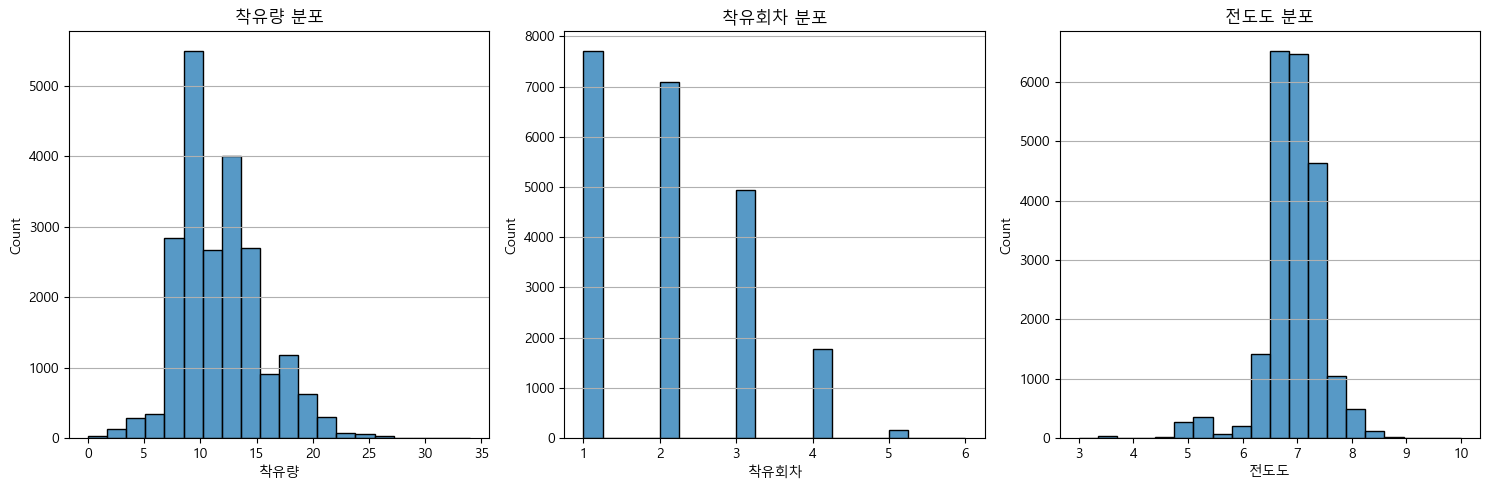

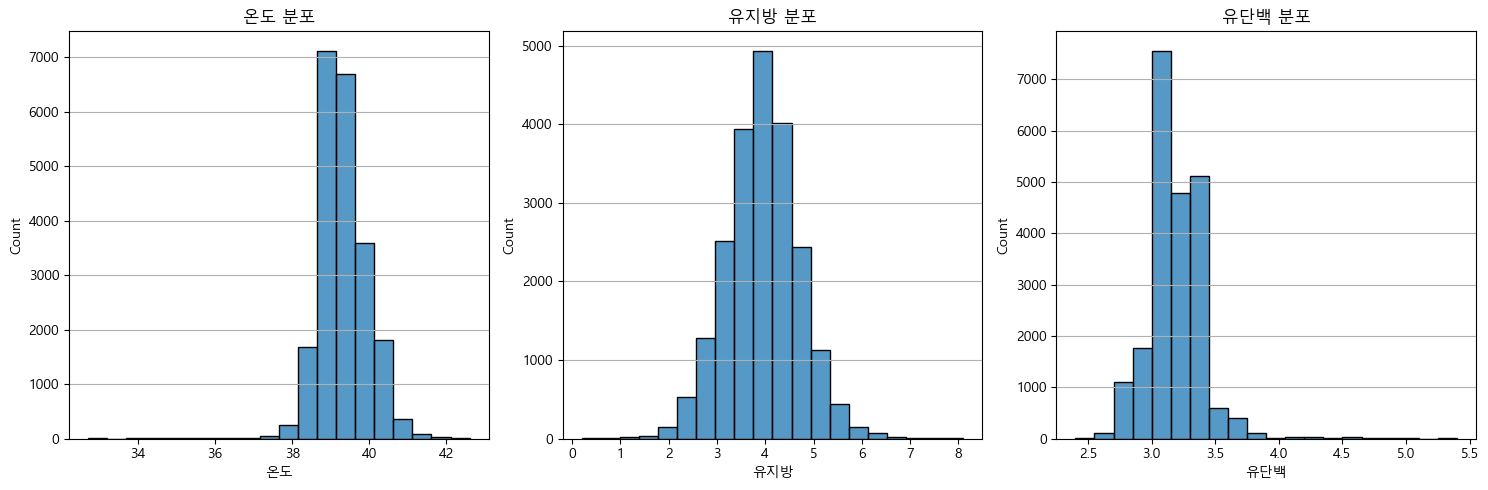

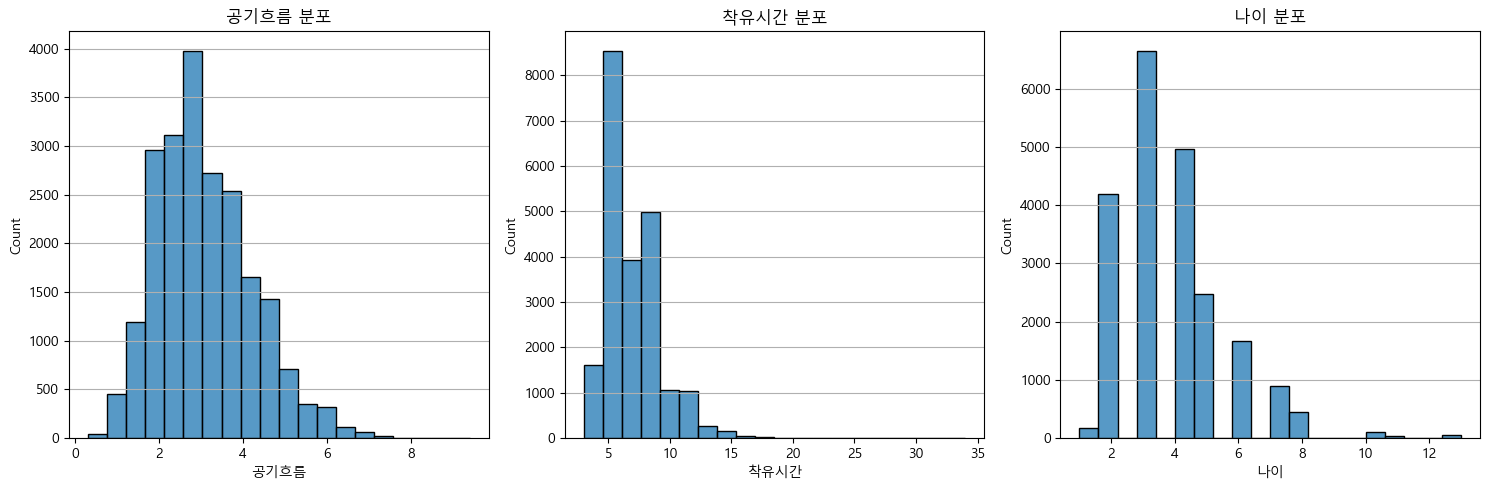

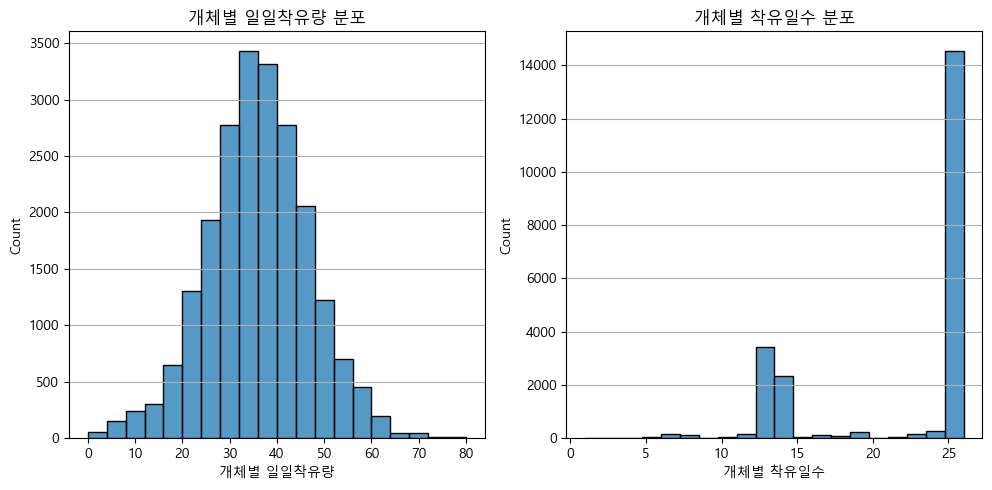

In [ ]:
cols = ["착유량","개체번호","공기흐름_비율","P/F ratio","개체별 착유일수","측정일","착유회차","농장아이디","착유시간","유지방","유단백"]

cols_group = [["착유량","착유회차","전도도"],["온도","유지방","유단백"],["공기흐름","착유시간","나이"],["개체별 일일착유량","개체별 착유일수"]]

for x, y in enumerate(cols_group):
    plt.figure(figsize=(15,5))
    
    for i, col in enumerate(y):
        plt.subplot(1,3,i+1)
        sns.histplot(data=df, x=col, bins=20)
        plt.title(f"{col} 분포")
        plt.grid(axis='y', alpha=1)
    plt.tight_layout()
    plt.show()

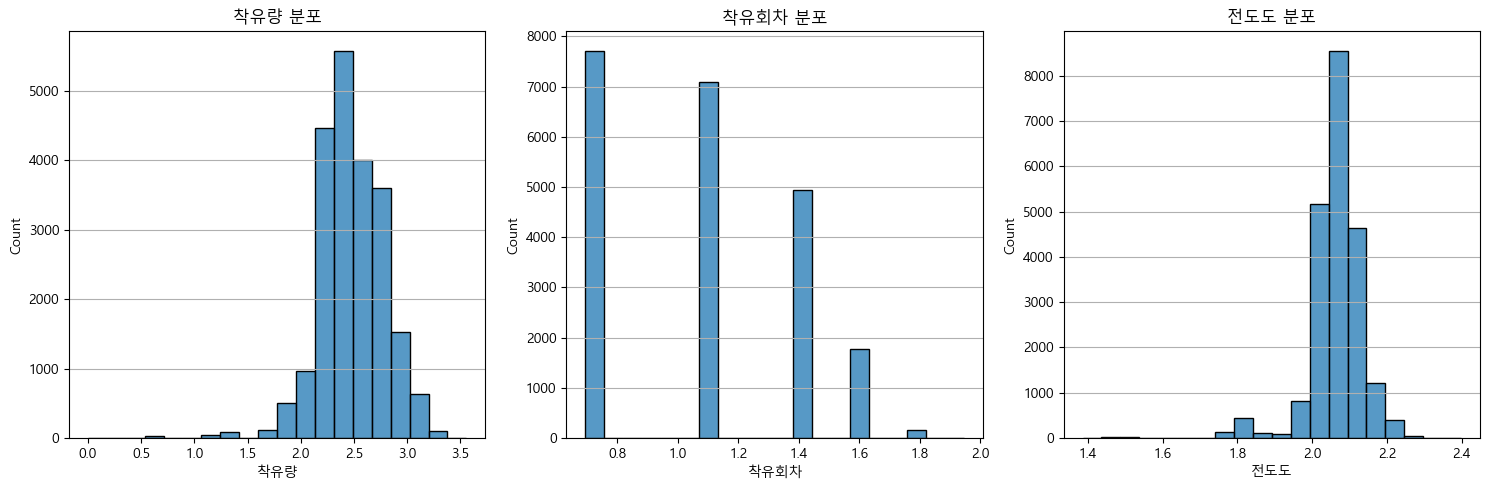

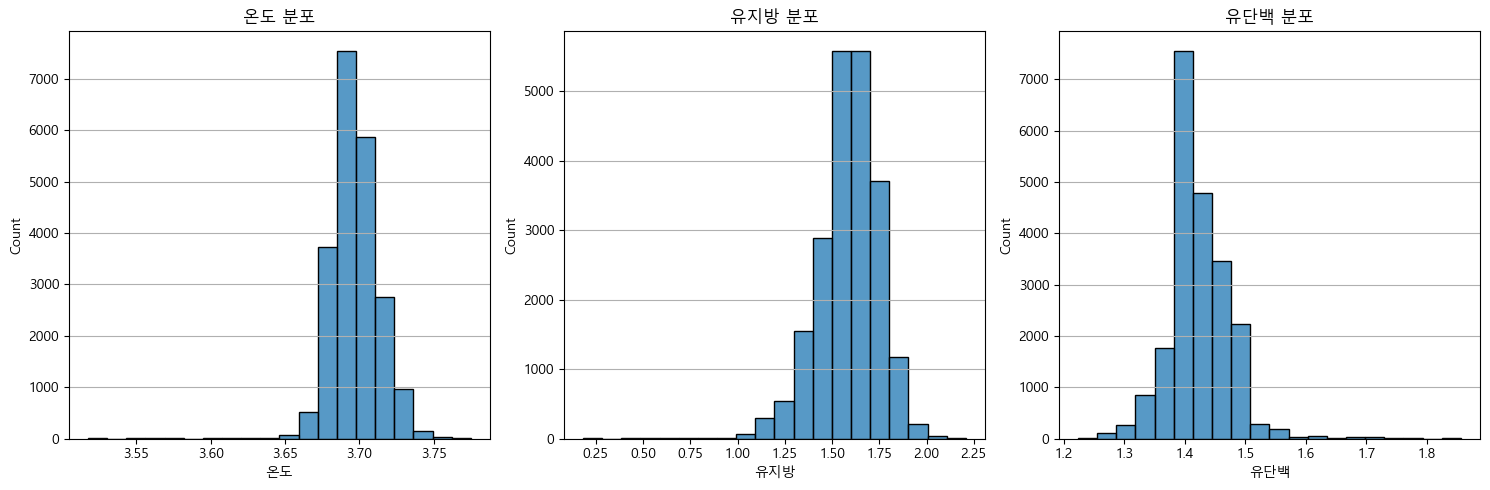

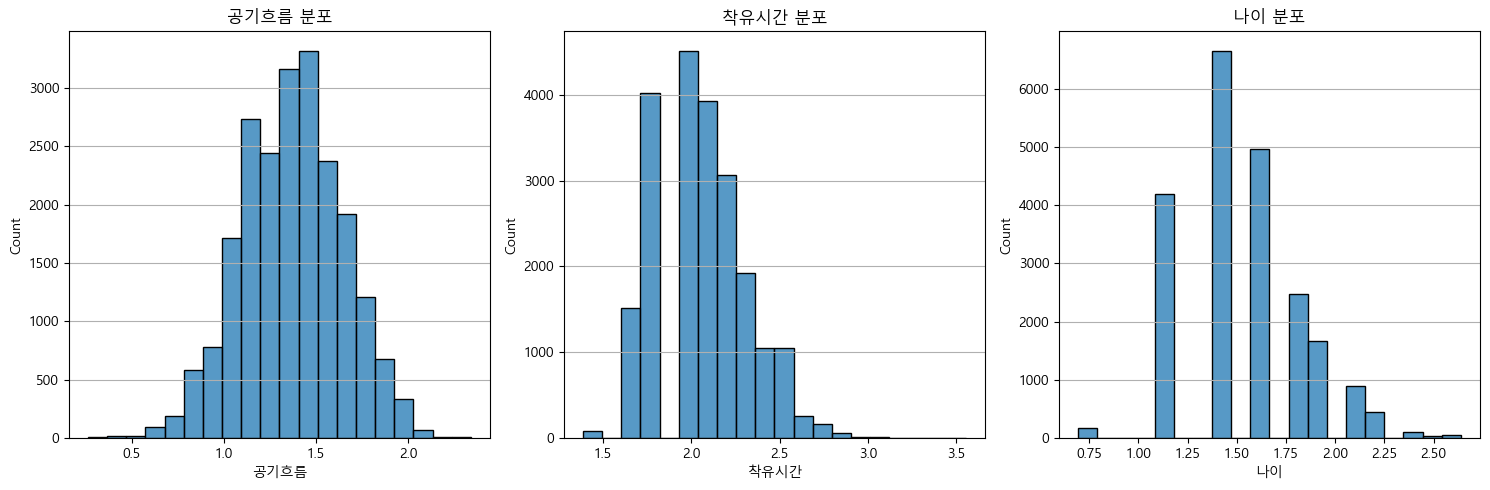

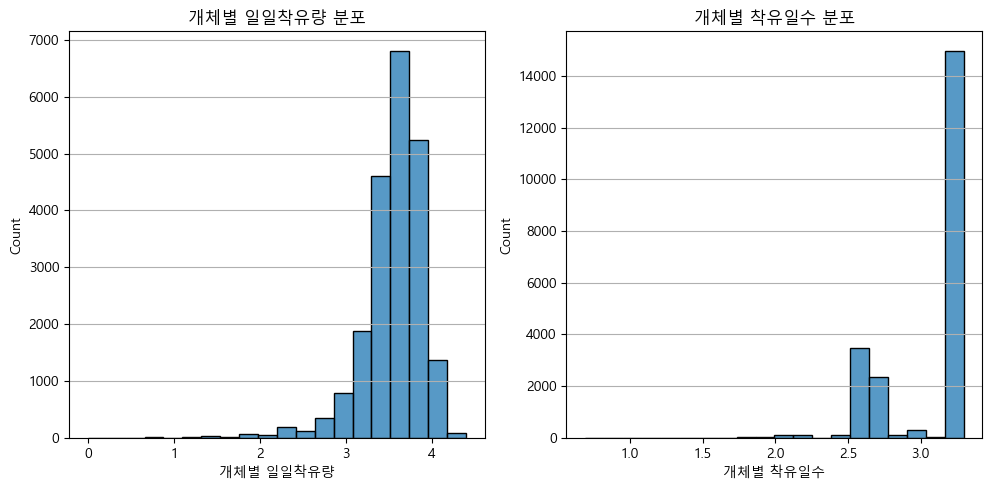

In [451]:
cols = ["전도도","온도","공기흐름","유지방","유단백","착유량","착유시간","나이","개체별 일일착유량","개체별 착유일수"]

cols_group = [["착유량","착유회차","전도도"],["온도","유지방","유단백"],["공기흐름","착유시간","나이"],["개체별 일일착유량","개체별 착유일수"]]

for x, y in enumerate(cols_group):
    plt.figure(figsize=(15,5))
    
    for i, col in enumerate(y):
        plt.subplot(1,3,i+1)

        log_transformed_col = np.log(df[col]+1)
        df[f"{col}_log"] = log_transformed_col
        sns.histplot(data=log_transformed_col, bins=20)
        plt.title(f"{col} 분포")
        plt.grid(axis='y', alpha=1)
    plt.tight_layout()
    plt.show()

In [132]:
df.head()

,농장아이디,개체번호,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,혈액흐름,온도,유지방,유단백,공기흐름,수집일자,착유시간,나이,측정일,개체별 일일착유량,개체별 착유일수,착유량_log,착유회차_log,전도도_log,온도_log,유지방_log,유단백_log,공기흐름_log,착유시간_log,나이_log,개체별 일일착유량_log,개체별 착유일수_log
0,20278,20130816010079,2021-09-01 06:52:00,16,2021-09-01 06:52:00,2021-09-01 07:04:00,1,7.1,0,39.9,4.1,3.3,1.5,20210902,12.0,8,1,33,26,2.833213,0.693147,2.091864,3.711130,1.629241,1.458615,0.916291,2.564949,2.197225,3.526361,3.295837
1,20278,20130816010079,2021-09-01 17:02:00,17,2021-09-01 17:02:00,2021-09-01 17:11:00,2,6.8,0,40.2,4.5,3.2,2.1,20210902,9.0,8,1,33,26,2.890372,1.098612,2.054124,3.718438,1.704748,1.435085,1.131402,2.302585,2.197225,3.526361,3.295837
2,20278,20130816010079,2021-09-02 01:41:00,14,2021-09-02 01:41:00,2021-09-02 01:51:00,1,6.8,0,39.9,4.8,3.1,1.9,20210903,10.0,8,2,35,26,2.708050,0.693147,2.054124,3.711130,1.757858,1.410987,1.064711,2.397895,2.197225,3.583519,3.295837
3,20278,20130816010079,2021-09-02 07:28:00,10,2021-09-02 07:28:00,2021-09-02 07:36:00,2,6.8,0,39.6,5.0,3.1,1.7,20210903,8.0,8,2,35,26,2.397895,1.098612,2.054124,3.703768,1.791759,1.410987,0.993252,2.197225,2.197225,3.583519,3.295837
4,20278,20130816010079,2021-09-02 14:33:00,11,2021-09-02 14:33:00,2021-09-02 14:45:00,3,6.8,0,40.0,4.7,3.2,1.3,20210903,12.0,8,2,35,26,2.484907,1.386294,2.054124,3.713572,1.740466,1.435085,0.832909,2.564949,2.197225,3.583519,3.295837


# 기본적인 전처리 후 xgboost 돌려보기 (기존, log변환 후)

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


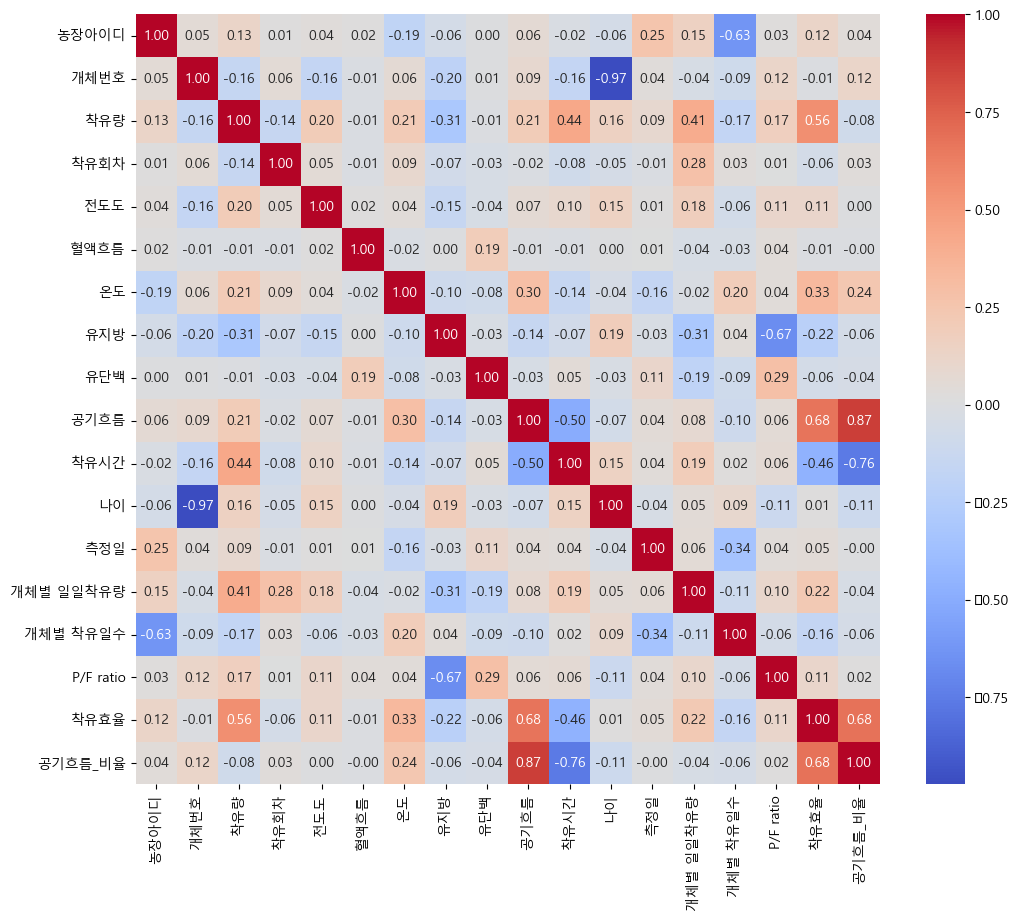

In [406]:
correlation_matrix = df_clean.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap = "coolwarm")
plt.show()

In [500]:
df_clean.columns

Index(['농장아이디', '개체번호', '착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도', '혈액흐름', '온도',
       '유지방', '유단백', '공기흐름', '착유시간', '나이', '측정일', '개체별 일일착유량', '개체별 착유일수',
       'P/F ratio', '착유효율', '공기흐름_비율'],
      dtype='object')

In [501]:
df_clean["착유량"].mean()

np.float64(11.777054631828978)

In [529]:
df.columns

Index(['농장아이디', '개체번호', '착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도', '혈액흐름', '온도',
       '유지방', '유단백', '공기흐름', '착유시간', '나이', '측정일', '개체별 일일착유량', '개체별 착유일수',
       'P/F ratio', '착유효율', '공기흐름_비율'],
      dtype='object')

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\User\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


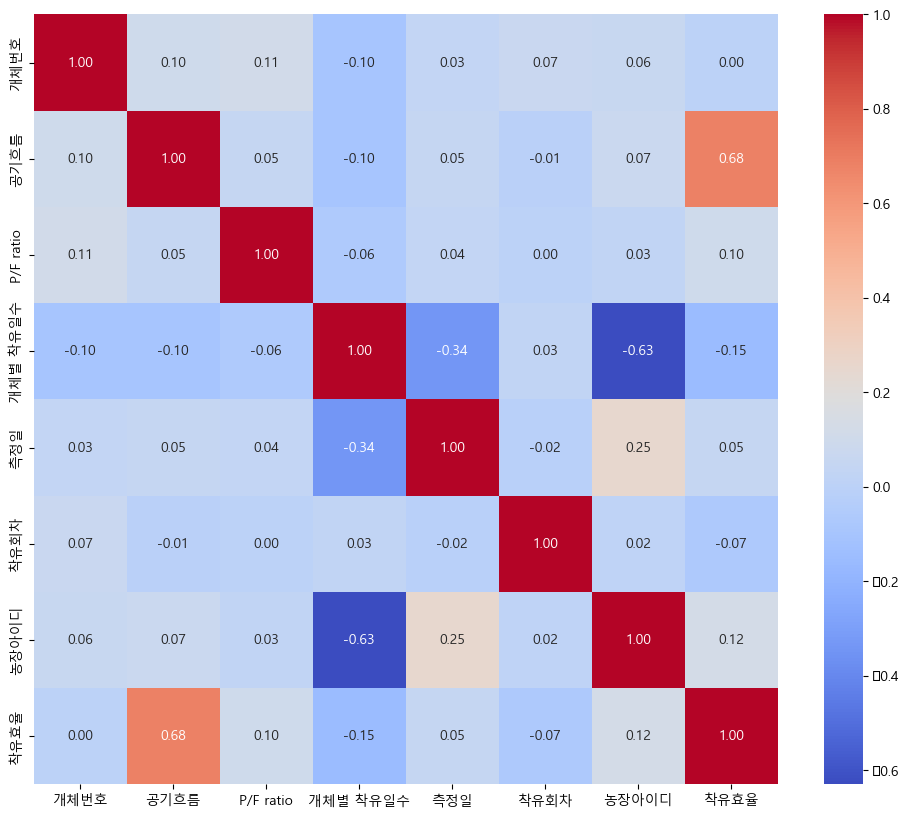

In [533]:
correlation_matrix = df[["개체번호","공기흐름","P/F ratio","개체별 착유일수","측정일","착유회차","농장아이디","착유효율"]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap = "coolwarm")
plt.show()

학습 데이터 X_train 형태: (17326, 8)
검증 데이터 X_test 형태: (4332, 8)
----------------------------------------

--- 모델 평가 결과 ---
Mean Squared Error (MSE): 2.01
Root Mean Squared Error (RMSE): 1.42
R-squared (R2): 0.85
Mean Absolute Percentage Error (MAPE): 181201862656000.00%
----------------------------------------
교차검증 R2: 0.8327
과적합 정도: 0.0154

--- 피처 중요도 순위 ---
     Feature  Importance
7       착유시간    0.437292
6      농장아이디    0.146197
1    공기흐름_비율    0.115114
3   개체별 착유일수    0.094415
0       개체번호    0.090135
2  P/F ratio    0.063885
5       착유회차    0.034851
4        측정일    0.018112


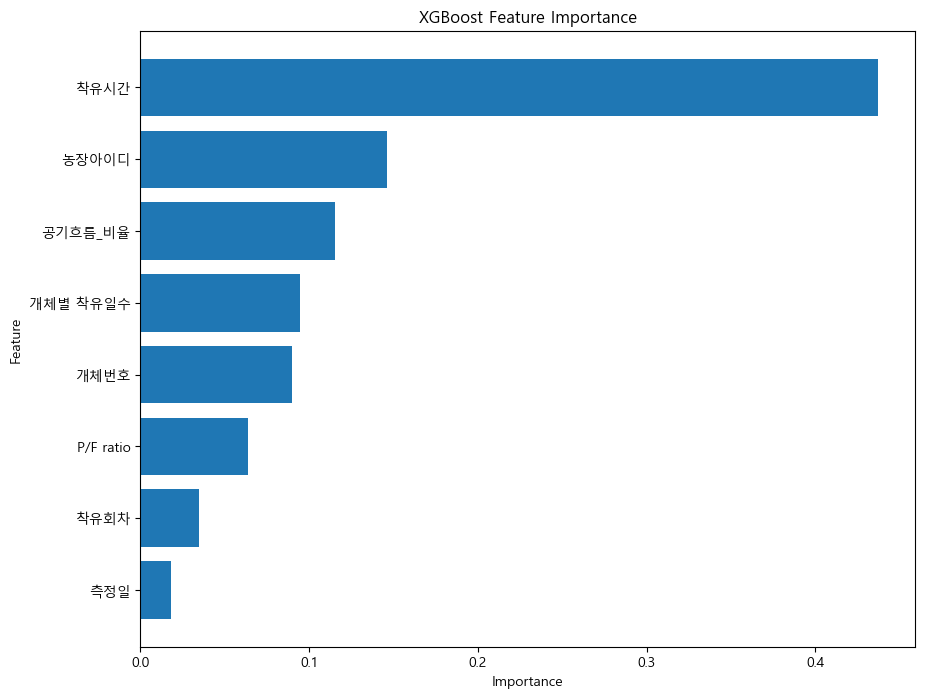

In [ ]:
# 특성(X)과 타겟(y) 분리
# '착유량'이 예측하려는 타겟 변수
X = df[["개체번호","공기흐름_비율","P/F ratio","개체별 착유일수","측정일","착유회차","농장아이디","착유시간"]]
y = df['착유량']
# 학습 세트와 검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"학습 데이터 X_train 형태: {X_train.shape}")
print(f"검증 데이터 X_test 형태: {X_test.shape}")
print("-" * 40)
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 6, 8, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 정규화
    'reg_lambda': [0, 0.1, 0.5, 1.0]  # L2 정규화
}
# --- XGBoost 모델 생성 및 학습 ---
xgb_model = xgb.XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(
    xgb_model, param_grid, n_iter=50,
    cv=5, scoring='r2', random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
# 검증 세트에 대한 예측
y_pred = random_search.predict(X_test)
# 성능 지표 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100 # %로 변환

print(f"\n--- 모델 평가 결과 ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("-" * 40)

# 과적합 확인
cv_scores3 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print(f"교차검증 R2: {cv_scores3.mean():.4f}")
print(f"과적합 정도: {abs(cv_scores3.mean() - r2):.4f}")

# --- 피처 중요도 체크 코드 시작 ---

# 피처(특성)의 이름 리스트 가져오기
feature_names = X_test.columns

# best_model에서 피처 중요도 점수 가져오기
importance_scores = best_model.feature_importances_

# 피처 이름과 중요도 점수를 데이터프레임으로 만들기
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
})

# 중요도 점수가 높은 순서대로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\n--- 피처 중요도 순위 ---")
print(feature_importance_df)

# 중요도를 시각화하여 확인 (선택 사항)
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis() # 가장 중요한 피처가 맨 위에 오도록 정렬
plt.show()

학습 데이터 X_train 형태: (16840, 8)
검증 데이터 X_test 형태: (4210, 8)
----------------------------------------

--- 모델 평가 결과 ---
Mean Squared Error (MSE): 2.06
Root Mean Squared Error (RMSE): 1.44
R-squared (R2): 0.84
Mean Absolute Percentage Error (MAPE): 15147863244800.00%
----------------------------------------
교차검증 R2: 0.8383
과적합 정도: 0.0041

--- 피처 중요도 순위 ---
     Feature  Importance
0       개체번호    0.379496
7       착유시간    0.260622
6      농장아이디    0.092713
1    공기흐름_비율    0.078171
2  P/F ratio    0.061935
3   개체별 착유일수    0.054683
5       착유회차    0.052245
4        측정일    0.020135


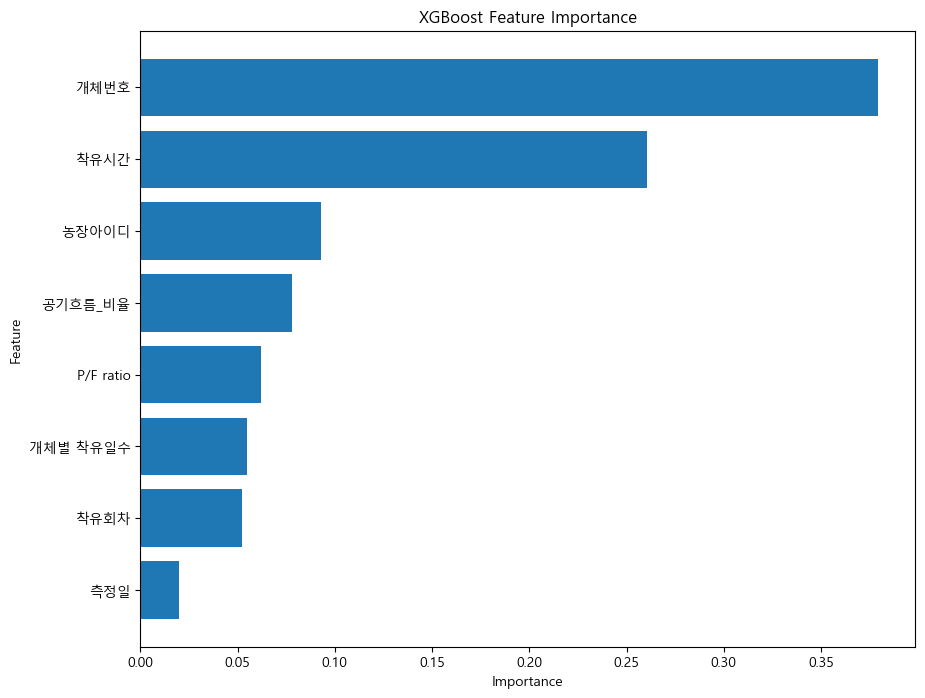

In [545]:
# 특성(X)과 타겟(y) 분리
# '착유량'이 예측하려는 타겟 변수

X = df_clean[["개체번호","공기흐름_비율","P/F ratio","개체별 착유일수","측정일","착유회차","농장아이디","착유시간"]]
y = df_clean['착유량']
                      
# 학습 세트와 검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터 X_train 형태: {X_train.shape}")
print(f"검증 데이터 X_test 형태: {X_test.shape}")
print("-" * 40)

cat_feats = ['농장아이디','개체번호']
te = TargetEncoder(cols=cat_feats)
X_train_encoded = te.fit_transform(X_train, y_train)

X_test_encoded = te.transform(X_test)

param_grid = {
    'n_estimators': [250, 300, 350, 400],
    'learning_rate': [0.08, 0.1, 0.12],
    'max_depth': [4, 5, 6],
    'subsample': [0.85, 0.9, 0.95],
    'colsample_bytree': [0.85, 0.9, 0.95],
    'reg_alpha': [0.3, 0.5, 0.7],  # L1 정규화
    'reg_lambda': [0.3, 0.5, 0.7]  # L2 정규화
}
# --- XGBoost 모델 생성 및 학습 ---
xgb_model = xgb.XGBRegressor(random_state=42 , verbosity=0)
random_search = RandomizedSearchCV(
    xgb_model, param_grid, n_iter=30, 
    cv=5, scoring='r2', random_state=42, n_jobs=-1
)
random_search.fit(X_train_encoded, y_train)
best_model = random_search.best_estimator_

# 검증 세트에 대한 예측
y_pred = random_search.predict(X_test_encoded)

# 성능 지표 계산
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100 # %로 변환

print(f"\n--- 모델 평가 결과 ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("-" * 40)

# 과적합 확인
cv_scores3 = cross_val_score(best_model, X_train_encoded, y_train, cv=5, scoring='r2')
print(f"교차검증 R2: {cv_scores3.mean():.4f}")
print(f"과적합 정도: {abs(cv_scores3.mean() - r2):.4f}")

# --- 피처 중요도 체크 코드 시작 ---

# 피처(특성)의 이름 리스트 가져오기
feature_names = X_test_encoded.columns

# best_model에서 피처 중요도 점수 가져오기
importance_scores = best_model.feature_importances_

# 피처 이름과 중요도 점수를 데이터프레임으로 만들기
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
})

# 중요도 점수가 높은 순서대로 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\n--- 피처 중요도 순위 ---")
print(feature_importance_df)

# 중요도를 시각화하여 확인 (선택 사항)
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis() # 가장 중요한 피처가 맨 위에 오도록 정렬
plt.show()

# 랜덤 포레스트

In [503]:
X = df_clean[["농장아이디","개체번호","전도도", "공기흐름", "유지방", "유단백", "온도", "나이", "P/F ratio","착유시간"]]
y = df_clean['착유량']

# 학습 세트와 검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터 X_train 형태: {X_train.shape}")
print(f"검증 데이터 X_test 형태: {X_test.shape}")
print("-" * 40)

# 범주형 변수 인코딩
cat_feats = ['농장아이디','개체번호']
te = TargetEncoder(cols=cat_feats)
X_train_encoded = te.fit_transform(X_train, y_train)
X_test_encoded = te.transform(X_test)

rf_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestRegressor(random_state=42)
rf_random_search = RandomizedSearchCV(
    rf_model, rf_param_grid, n_iter=50,
    cv=5, scoring='r2', random_state=42, n_jobs=-1
)
rf_random_search.fit(X_train_encoded, y_train)
rf_best_model = rf_random_search.best_estimator_

# 예측 및 평가
rf_y_pred = rf_random_search.predict(X_test_encoded)
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_y_pred)

Random_Forest = {'MSE': rf_mse, 'RMSE': rf_rmse, 'R2': rf_r2, 'model': rf_best_model}

print(f"Random Forest - MSE: {rf_mse:.2f}, RMSE: {rf_rmse:.2f}, R2: {rf_r2:.2f}")

# 피처 중요도
rf_feature_importance = pd.DataFrame({
    'Feature': X_test_encoded.columns,
    'Importance': rf_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- Random Forest 피처 중요도 ---")
print(rf_feature_importance)

학습 데이터 X_train 형태: (16840, 10)
검증 데이터 X_test 형태: (4210, 10)
----------------------------------------


KeyboardInterrupt: 

# lightgbm

In [ ]:
X = df_clean[["농장아이디","개체번호","전도도", "공기흐름", "유지방", "유단백", "온도", "나이", "P/F ratio","착유시간"]]
y = df_clean['착유량']

# 학습 세트와 검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터 X_train 형태: {X_train.shape}")
print(f"검증 데이터 X_test 형태: {X_test.shape}")
print("-" * 40)

# 범주형 변수 인코딩
cat_feats = ['농장아이디','개체번호']
te = TargetEncoder(cols=cat_feats)
X_train_encoded = te.fit_transform(X_train, y_train)
X_test_encoded = te.transform(X_test)

lgb_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 6, 8, 10],
    'num_leaves': [31, 50, 100, 150],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)
lgb_random_search = RandomizedSearchCV(
    lgb_model, lgb_param_grid, n_iter=50,
    cv=5, scoring='r2', random_state=42, n_jobs=-1
)
lgb_random_search.fit(X_train_encoded, y_train)
lgb_best_model = lgb_random_search.best_estimator_

# 예측 및 평가
lgb_y_pred = lgb_random_search.predict(X_test_encoded)
lgb_mse = mean_squared_error(y_test, lgb_y_pred)
lgb_rmse = np.sqrt(lgb_mse)
lgb_r2 = r2_score(y_test, lgb_y_pred)

results_LightGBM = {'MSE': lgb_mse, 'RMSE': lgb_rmse, 'R2': lgb_r2, 'model': lgb_best_model}

print(f"LightGBM - MSE: {lgb_mse:.2f}, RMSE: {lgb_rmse:.2f}, R2: {lgb_r2:.2f}")

# 피처 중요도
lgb_feature_importance = pd.DataFrame({
    'Feature': X_test_encoded.columns,
    'Importance': lgb_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- LightGBM 피처 중요도 ---")
print(lgb_feature_importance)


학습 데이터 X_train 형태: (17326, 9)
검증 데이터 X_test 형태: (4332, 9)
----------------------------------------
LightGBM - MSE: 2.08, RMSE: 1.44, R2: 0.84

--- LightGBM 피처 중요도 ---
   Feature  Importance
3  공기흐름_비율        4722
1     개체번호        4039
5      유지방        3419
7       온도        3057
2      전도도        2676
6      유단백        1979
4     착유시간        1947
8       나이        1203
0    농장아이디         964


# gradiant_boosting

In [267]:
X = df[["개체번호", "전도도", "공기흐름_비율", "착유시간","유지방","유단백","온도","나이"]]
y = df['착유량']

# 학습 세트와 검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터 X_train 형태: {X_train.shape}")
print(f"검증 데이터 X_test 형태: {X_test.shape}")
print("-" * 40)

# 범주형 변수 인코딩
cat_feats = ['개체번호']
te = TargetEncoder(cols=cat_feats)
X_train_encoded = te.fit_transform(X_train, y_train)
X_test_encoded = te.transform(X_test)

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 6, 8],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

gb_model = GradientBoostingRegressor(random_state=42)
gb_random_search = RandomizedSearchCV(
    gb_model, gb_param_grid, n_iter=30,
    cv=5, scoring='r2', random_state=42, n_jobs=-1
)
gb_random_search.fit(X_train_encoded, y_train)
gb_best_model = gb_random_search.best_estimator_

# 예측 및 평가
gb_y_pred = gb_random_search.predict(X_test_encoded)
gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_rmse = np.sqrt(gb_mse)
gb_r2 = r2_score(y_test, gb_y_pred)

results_Gradient_Boosting= {'MSE': gb_mse, 'RMSE': gb_rmse, 'R2': gb_r2, 'model': gb_best_model}

print(f"Gradient Boosting - MSE: {gb_mse:.2f}, RMSE: {gb_rmse:.2f}, R2: {gb_r2:.2f}")

# 피처 중요도
gb_feature_importance = pd.DataFrame({
    'Feature': X_test_encoded.columns,
    'Importance': gb_best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n--- Gradient Boosting 피처 중요도 ---")
print(gb_feature_importance)


학습 데이터 X_train 형태: (17326, 8)
검증 데이터 X_test 형태: (4332, 8)
----------------------------------------
Gradient Boosting - MSE: 2.12, RMSE: 1.46, R2: 0.84

--- Gradient Boosting 피처 중요도 ---
   Feature  Importance
0     개체번호    0.569025
3     착유시간    0.128489
2  공기흐름_비율    0.115246
4      유지방    0.065734
6       온도    0.038938
5      유단백    0.035196
1      전도도    0.028291
7       나이    0.019081


# 앙상블

학습 데이터 X_train 형태: (16840, 10)
검증 데이터 X_test 형태: (4210, 10)
----------------------------------------

--- XGBoost 모델 학습 시작 ---
--- XGBoost 모델 학습 완료 ---
----------------------------------------

--- 모델 평가 결과 ---
Mean Squared Error (MSE): 2.13
Root Mean Squared Error (RMSE): 1.46
R-squared (R2): 0.84
mape: 35171637657600.00
----------------------------------------
교차검증 R2: 0.8408
과적합 정도: 0.0031

--- XGBoost 모델의 피처 중요도 순위 (스태킹 내) ---
     Feature  Importance
1       개체번호    0.526393
9       착유시간    0.146863
3       공기흐름    0.084342
8  P/F ratio    0.065436
7         나이    0.041117
0      농장아이디    0.036924
4        유지방    0.031223
5        유단백    0.028492
6         온도    0.024278
2        전도도    0.014931


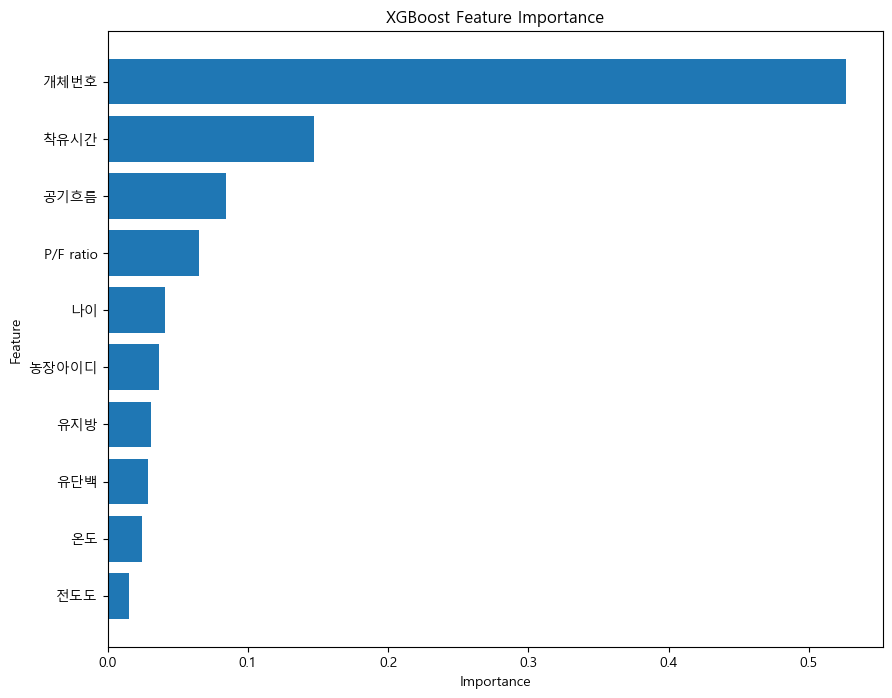

In [507]:
# 특성(X)과 타겟(y) 분리
# '착유량'이 예측하려는 타겟 변수

X = df_clean[["농장아이디","개체번호","전도도", "공기흐름", "유지방", "유단백", "온도", "나이", "P/F ratio","착유시간"]]
y = df_clean['착유량']
                      
# 학습 세트와 검증 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터 X_train 형태: {X_train.shape}")
print(f"검증 데이터 X_test 형태: {X_test.shape}")
print("-" * 40)

cat_feats = ['농장아이디','개체번호']
te = TargetEncoder(cols=cat_feats)
X_train_encoded = te.fit_transform(X_train, y_train)

X_test_encoded = te.transform(X_test)

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 6, 8, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 정규화
    'reg_lambda': [0, 0.1, 0.5, 1.0]  # L2 정규화
}
models = {
    'xgboost': xgb.XGBRegressor(
        n_estimators=300, 
        learning_rate=0.05, 
        max_depth=6,
        random_state=42
    ),
    'lightgbm': lgb.LGBMRegressor(
        n_estimators=300, 
        learning_rate=0.05, 
        max_depth=6,
        random_state=42,
        verbose=-1  # 출력 억제
    ),
    'random_forest': RandomForestRegressor(
        n_estimators=200, 
        max_depth=10,
        random_state=42
    ),
    'gradient_boost': GradientBoostingRegressor(
        n_estimators=200, 
        learning_rate=0.05,
        random_state=42
    )
}
# 스태킹 모델 정의
stacking_regressor = StackingRegressor(
    estimators=list(models.items()),
    final_estimator=LinearRegression(),  # Meta model
    cv=5,  # 5-fold 교차검증
    n_jobs=-1  # 병렬처리
)

# 스태킹 모델 학습
print("\n--- XGBoost 모델 학습 시작 ---")
stacking_regressor.fit(X_train_encoded, y_train)
print("--- XGBoost 모델 학습 완료 ---")
print("-" * 40)

# 스태킹 모델에 대한 예측
y_pred_stacking = stacking_regressor.predict(X_test_encoded)


# 성능 지표 계산
mse = mean_squared_error(y_test, y_pred_stacking)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_stacking)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100 # %로 변환

print(f"\n--- 모델 평가 결과 ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")
print(f"mape: {mape:.2f}")
print("-" * 40)

# 과적합 확인
cv_scores3 = cross_val_score(best_model, X_train_encoded, y_train, cv=5, scoring='r2')
print(f"교차검증 R2: {cv_scores3.mean():.4f}")
print(f"과적합 정도: {abs(cv_scores3.mean() - r2):.4f}")

# --- 피처 중요도 체크 코드 시작 ---

xgb_model_in_stack = stacking_regressor.named_estimators_['xgboost']
feature_names = X_test_encoded.columns
importance_scores = xgb_model_in_stack.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

print("\n--- XGBoost 모델의 피처 중요도 순위 (스태킹 내) ---")
print(feature_importance_df)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()


# 시계열 머신러닝